# Time series Analysis using SARIMAX

In this notebook, we are using kaggle's 'Residential Power Usage in US' dataset for predicting the power consumption of a house in United States. 

You can able to download the data set using below kaggle's link

https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries

In [1]:
#Importing All necessary Libraries

#Basic Libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for data time converstions and operations
import datetime as dt

#for Seasonal Decompose
from statsmodels.tsa.seasonal import seasonal_decompose

#for statiority check
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff

#for ploting acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#for TS model
from statsmodels.tsa.arima_model import ARIMA

#for error metrics
from sklearn.metrics import mean_squared_error

#for finding the best params for TS model
import pmdarima
from pmdarima import auto_arima
import itertools


# Data Cleaning

### Cleaning Power Consumption Data

In [2]:
#Lets import the power consumption data
df_power_consumption = pd.read_csv('C:/Users/kqsr247/Box Sync/Learning/01_IBM_AI_ENGINEER/01_Machine_Learning_with_Python/My_Expo/Time_Series_Modelling/Power_Consuption_Kaggle/Data/power_usage_2016_to_2020.csv')
df_power_consumption.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [3]:
#lets look at the column types
df_power_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


For time series data, we always need to have the date to be of datetime datatype and it should be the index of the dataset to start further analysis.

So Let's convert it into Datetime. And also, we don't need a hourly prediction of power consumption. In practtical it is very difficult to predict the power consumption on hourly basis. so lets aggregate the values based on date.

In [4]:
# Date column update for 'df_power_consumption'
n = df_power_consumption.shape[0]
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq = '1H', periods = n))
df_power_consumption['StartDate'] = p1.to_frame().index


# convert the period date into timestamp
df_power_consumption['StartDate'] = df_power_consumption['StartDate'].apply (lambda x: x.to_timestamp())
df_power_consumption['Date'] = pd.DatetimeIndex(df_power_consumption['StartDate']).date

In [5]:
#Converting hourly consumption to daily consumption
df_daily_consumption = df_power_consumption.groupby('Date').sum()

df_daily_consumption['day_of_week'] = df_power_consumption['day_of_week'].apply(lambda x: x/24)

notes_col = df_power_consumption.groupby('Date').first()['notes'].values
df_daily_consumption['notes'] = notes_col
df_daily_consumption.head(10)

,Value (kWh),day_of_week,notes
Date,,,
2016-06-01,29.691,NaN,weekday
2016-06-02,28.789,NaN,weekend
2016-06-03,19.247,NaN,weekend
2016-06-04,22.883,NaN,weekday
2016-06-05,25.195,NaN,weekday
2016-06-06,29.323,NaN,weekday
2016-06-07,30.322,NaN,weekday
2016-06-08,40.051,NaN,weekend
2016-06-09,38.667,NaN,weekday


### Cleaning Weather Consumption Data

In [6]:
#Lets import the power consumption data
df_weather = pd.read_csv('C:/Users/kqsr247/Box Sync/Learning/01_IBM_AI_ENGINEER/01_Machine_Learning_with_Python/My_Expo/Time_Series_Modelling/Power_Consuption_Kaggle/Data/weather_2016_2020_daily.csv')
df_weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [7]:
#lets look at the column types
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1552 non-null   object 
 1   Day          1552 non-null   int64  
 2   Temp_max     1552 non-null   int64  
 3   Temp_avg     1552 non-null   float64
 4   Temp_min     1552 non-null   int64  
 5   Dew_max      1552 non-null   int64  
 6   Dew_avg      1552 non-null   float64
 7   Dew_min      1552 non-null   int64  
 8   Hum_max      1552 non-null   int64  
 9   Hum_avg      1552 non-null   float64
 10  Hum_min      1552 non-null   int64  
 11  Wind_max     1552 non-null   int64  
 12  Wind_avg     1552 non-null   float64
 13  Wind_min     1552 non-null   int64  
 14  Press_max    1552 non-null   float64
 15  Press_avg    1552 non-null   float64
 16  Press_min    1552 non-null   float64
 17  Precipit     1552 non-null   float64
 18  day_of_week  1552 non-null   int64  
dtypes: flo

As we did it for the power consumption data, we need to convert the date column into datetime datatype and need to apply the condition

In [8]:
# Date column update for 'df_weather'
m = df_weather.shape[0]
p2 = pd.Series(range(m), pd.period_range('2016-06-01', freq = '1D', periods = m))
df_weather['Date'] = p2.to_frame().index

# convert the period date into timestamp
df_weather['Date'] = df_weather['Date'].apply (lambda x: x.to_timestamp())

In [9]:
# Lets view the datatype
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1552 non-null   datetime64[ns]
 1   Day          1552 non-null   int64         
 2   Temp_max     1552 non-null   int64         
 3   Temp_avg     1552 non-null   float64       
 4   Temp_min     1552 non-null   int64         
 5   Dew_max      1552 non-null   int64         
 6   Dew_avg      1552 non-null   float64       
 7   Dew_min      1552 non-null   int64         
 8   Hum_max      1552 non-null   int64         
 9   Hum_avg      1552 non-null   float64       
 10  Hum_min      1552 non-null   int64         
 11  Wind_max     1552 non-null   int64         
 12  Wind_avg     1552 non-null   float64       
 13  Wind_min     1552 non-null   int64         
 14  Press_max    1552 non-null   float64       
 15  Press_avg    1552 non-null   float64       
 16  Press_

### Joining both Consumption and Weather datasets


Lets join both datasets based on the date column. For this we need to filter the weather data set to match the rows on the consumption data set.

In [10]:
#filter the weather data to match with power usage dataframe. 
k = df_daily_consumption.shape[0]
df_weather = df_weather[0:k]
df_weather.set_index('Date', inplace=True)
df_weather.head()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
Date,,,,,,,,,,,,,,,,,,
2016-06-01,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-06-02,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2016-06-03,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
2016-06-04,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
2016-06-05,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [11]:
#Combining weather data with usage data
df_final = pd.merge(df_weather,df_daily_consumption,left_index=True, right_index=True)

In [12]:
#Lets check the no of columns on the merged set
df_final.columns

Index(['Day', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg',
       'Dew_min', 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg',
       'Wind_min', 'Press_max', 'Press_avg', 'Press_min', 'Precipit',
       'day_of_week_x', 'Value (kWh)', 'day_of_week_y', 'notes'],
      dtype='object')

In [13]:
#Let's drop the unwanted columns
df_final.drop(columns= ['Temp_avg', 'Temp_min','Dew_avg',
       'Dew_min', 'Hum_avg', 'Hum_min', 'Wind_avg',
       'Wind_min','Press_avg', 'Press_min', 'Precipit','day_of_week_x', 'day_of_week_y'], inplace=True)

In [14]:
#lets fix index frequency as Daily
df_final.index.freq= 'D'
df_final.head()

,Day,Temp_max,Dew_max,Hum_max,Wind_max,Press_max,Value (kWh),notes
Date,,,,,,,,
2016-06-01,1,85,74,100,21,29.8,29.691,weekday
2016-06-02,2,76,74,100,18,29.8,28.789,weekend
2016-06-03,3,79,72,100,18,29.8,19.247,weekend
2016-06-04,4,76,73,100,20,29.8,22.883,weekday
2016-06-05,5,82,72,100,17,29.7,25.195,weekday


# EDA (Exploratory Data Analysis)

### NULL Check

In [15]:
#Checking the Nulls in Dataset 
df_final.isnull().sum()

Day            0
Temp_max       0
Dew_max        0
Hum_max        0
Wind_max       0
Press_max      0
Value (kWh)    0
notes          0
dtype: int64

So, we dont have any NULL's in the dataset.

If we find any NULL's we need to either remove it or updating it with its mean, median or mode values. Removing records will give you data loss.

Generaly in Time series, we need to fill forward or backward value of the data

Pandas Methods : fillna, dropna

### Checking for Duplicates

In [16]:
#Identifying Duplicates
df_final.duplicated().sum()

0

We don't have any duplicates on the data. If it is found, we need to remove that using 'drop_duplicates'

### Ploting the Time series

In [17]:
df_final.head()

,Day,Temp_max,Dew_max,Hum_max,Wind_max,Press_max,Value (kWh),notes
Date,,,,,,,,
2016-06-01,1,85,74,100,21,29.8,29.691,weekday
2016-06-02,2,76,74,100,18,29.8,28.789,weekend
2016-06-03,3,79,72,100,18,29.8,19.247,weekend
2016-06-04,4,76,73,100,20,29.8,22.883,weekday
2016-06-05,5,82,72,100,17,29.7,25.195,weekday


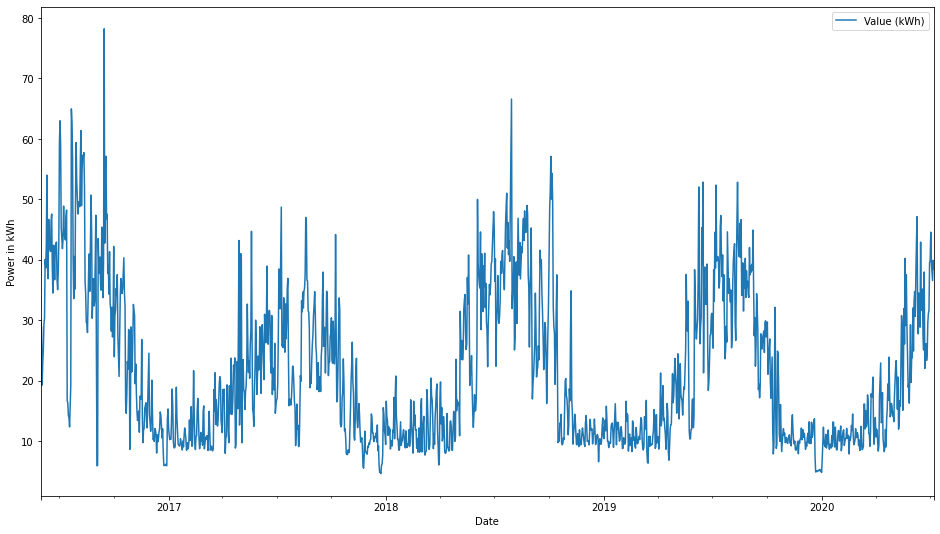

In [18]:
#let's plot the values
ax = df_final['Value (kWh)'].plot(figsize= (16,9), legend= True, ylabel='Power in kWh')
ax.autoscale(axis='x',tight=True)

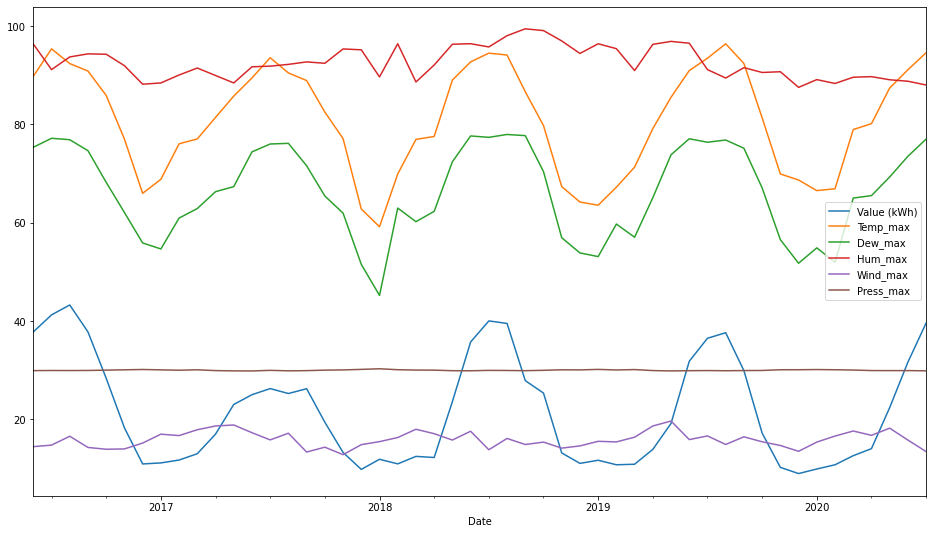

In [19]:
#let's plot the values of rest of the cols to check on the corelation between them
ax = df_final['Value (kWh)'].resample(rule='MS').mean().plot(figsize= (16,9), legend= True)
ax = df_final['Temp_max'].resample(rule='MS').mean().plot(figsize= (16,9), legend= True)
ax = df_final['Dew_max'].resample(rule='MS').mean().plot(figsize= (16,9), legend= True)
ax = df_final['Hum_max'].resample(rule='MS').mean().plot(figsize= (16,9), legend= True)
ax = df_final['Wind_max'].resample(rule='MS').mean().plot(figsize= (16,9), legend= True)
ax = df_final['Press_max'].resample(rule='MS').mean().plot(figsize= (16,9), legend= True)
ax.autoscale(axis='x',tight=True)

By looking at the plot, its obivious that the 'Temperature' and 'Dew' plays a major role in the trend of the power consumption. So, we will drop rest of the columns and keep only those cols.

In [20]:
df_final = df_final[['Value (kWh)','Temp_max','Dew_max','notes']]
df_final.head()

,Value (kWh),Temp_max,Dew_max,notes
Date,,,,
2016-06-01,29.691,85,74,weekday
2016-06-02,28.789,76,74,weekend
2016-06-03,19.247,79,72,weekend
2016-06-04,22.883,76,73,weekday
2016-06-05,25.195,82,72,weekday


### Seasonal Decompose


By looking at the above plot, its clear that we have a seasonal and trend compound. But we will decompse it using statsmodel and look at the results later

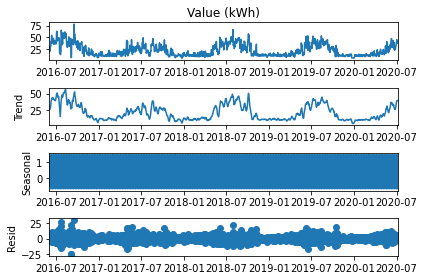

In [21]:
#for Seasonal Decompose
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(df_final['Value (kWh)'])
result.plot();

As we can't clearly notice the seasonal component, we will resample the data by monthly

In [22]:
df_final.tail(10)

,Value (kWh),Temp_max,Dew_max,notes
Date,,,,
2020-06-28,31.111,91,78,COVID_lockdown
2020-06-29,31.602,90,77,COVID_lockdown
2020-06-30,39.537,93,78,COVID_lockdown
2020-07-01,39.825,94,78,weekday
2020-07-02,44.567,96,77,weekday
2020-07-03,39.659,96,76,COVID_lockdown
2020-07-04,38.071,97,76,COVID_lockdown
2020-07-05,36.565,95,75,COVID_lockdown
2020-07-06,39.900,91,77,COVID_lockdown


### Data Resample

In [23]:
#Resampling for Monthly data
df_monthly_data = df_final.resample(rule='MS').mean()
df_monthly_data.head()

,Value (kWh),Temp_max,Dew_max
Date,,,
2016-06-01,37.778767,89.766667,75.333333
2016-07-01,41.237903,95.354839,77.161290
2016-08-01,43.249258,92.354839,76.870968
2016-09-01,37.757310,90.833333,74.633333
2016-10-01,28.329355,85.870968,68.193548


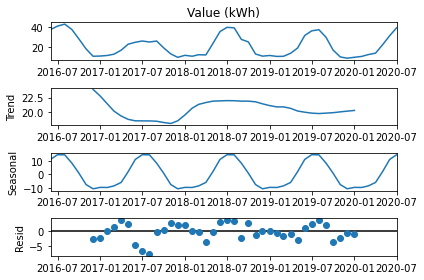

In [24]:
#for Seasonal Decompose for monthly data
from statsmodels.tsa.seasonal import seasonal_decompose 

monthly_result = seasonal_decompose(df_monthly_data['Value (kWh)'])
monthly_result.plot();

<AxesSubplot:xlabel='Date'>

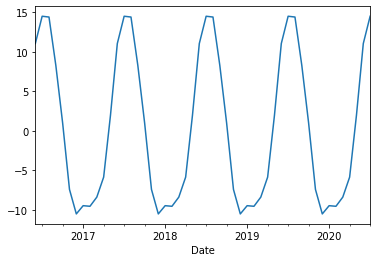

In [25]:
#Seasonal component from Seasonal decomposition
monthly_result.seasonal.plot()

<AxesSubplot:xlabel='Date'>

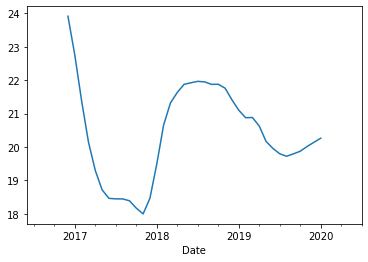

In [26]:
#Trend component from Seasonal decomposition
monthly_result.trend.plot()

We can able to notice clear trend. And the seasonal compund is falling in monthly pattern. So monthly resampling is working good.


By naked eye, we could able to see the data is not stationary. We will use 'Adfuller test' to check on the seasonality

### Test for stationarity

In [27]:
# lets import the corresponding library
from statsmodels.tsa.stattools import adfuller

#Lets create a function for the ad-fuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [28]:
adf_test(df_monthly_data['Value (kWh)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.691506
p-value                  0.075520
# lags used             11.000000
# observations          38.000000
critical value (1%)     -3.615509
critical value (5%)     -2.941262
critical value (10%)    -2.609200
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Conclusions arrived from the analysis

From the test, its clear that the data is non-stationary. --> Differencing needed

The data has Trend Component and Seasonal Component as well. --> Seasonal decomposition needed

The final value of power consumption is correlated with the Temp and Dew values. --> Need to algin the results with exogenus values


So, clearly we can make use of SARIMAX to make predictions


## Intro on SARIMAX

## SARIMA(p,d,q)(P,D,Q)m
### Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

# Identifying p, d, q Values

So, lets first identify d value which is the integration part of SARIMA. It denotes number of values to make the data Stationary

In [29]:
#importing Libs
from statsmodels.tsa.statespace.tools import diff

#first order differenceing
df_monthly_data['d1'] = diff(df_monthly_data['Value (kWh)'],k_diff=1)
#second order differenceing
df_monthly_data['d2'] = diff(df_monthly_data['Value (kWh)'],k_diff=2)

#adf test 
adf_test(df_monthly_data['d1'],'FOR 1st Differencing')
print('------------------------------------------------------')
adf_test(df_monthly_data['d2'],'FOR 2nd Differencing')

Augmented Dickey-Fuller Test: FOR 1st Differencing
ADF test statistic      -2.615532
p-value                  0.089829
# lags used             10.000000
# observations          38.000000
critical value (1%)     -3.615509
critical value (5%)     -2.941262
critical value (10%)    -2.609200
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
------------------------------------------------------
Augmented Dickey-Fuller Test: FOR 2nd Differencing
ADF test statistic      -5.603768
p-value                  0.000001
# lags used             10.000000
# observations          37.000000
critical value (1%)     -3.620918
critical value (5%)     -2.943539
critical value (10%)    -2.610400
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


So, the 1st order diffrence doesn't make the series stationary and in the 2nd order looks over diffrenced. so, we can consider the 1st order as a weak stationary series and take the value of d as 1

### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

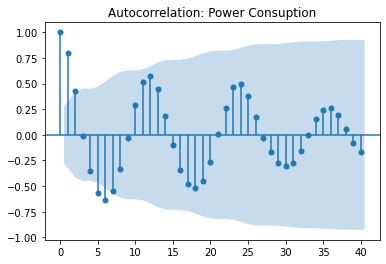

In [30]:
#importing libs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#acf plot 
title = 'Autocorrelation: Power Consuption'
lags = 40
plot_acf(df_monthly_data['Value (kWh)'],title=title,lags=lags);

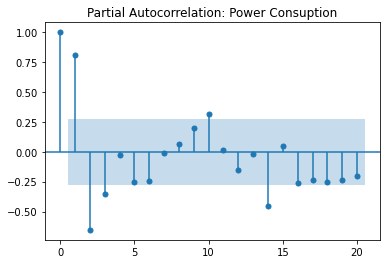

In [31]:
#pacf plot
title = 'Partial Autocorrelation: Power Consuption'
lags = 20
plot_pacf(df_monthly_data['Value (kWh)'],title=title,lags=lags);

## Conclusion on the p,q,d values

This tells us both AR(p) and MA(q) compenent has very narrow steep on the lagged series. Form the plots, tentatively we can consider P as 1 and q as 2.

For the value m, we know the seasonal is occuring every 12 months. so the m = 12.

But in realtime, we don't depend too much on the visual plots. Luckily Statsmodel have a package called autoarima from pmdarima, which tries all different possible combination and tells us a story which has higher impact on the specifie series.


Lets have a look at autoarima for the power consumption.

In [32]:
# Auto ARIMA for identifying the significant values

In [33]:
# import the libs
import pmdarima
from pmdarima import auto_arima

In [34]:
#auto_arima function for Power consuption
auto_arima = auto_arima(df_monthly_data['Value (kWh)'],seasonal=True,m=12)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   50
Model:             SARIMAX(0, 0, 3)x(1, 1, [1], 12)   Log Likelihood                 -98.053
Date:                              Wed, 18 Aug 2021   AIC                            208.106
Time:                                      10:56:48   BIC                            217.932
Sample:                                           0   HQIC                           211.602
                                               - 50                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8723      0.157      5.540      0.000       0.564       1.181
ma.L2          0.8647      0.168      5.158      0.000       0.536       1.193
ma.L3          0.1676      0.158      1.059      0.290      -0.143       0.478
ar.S.L12      -0.4117      0.292     -1.410      0.158      -0.984       0.161
ma.S.L12      -0.6340      0.807     -0.786      0.432      -2.216       0.948
sigma2         6.8269      3.958      1.725      0.085      -0.930      14.584
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.75   Prob(JB):                         0.70
Heteroskedasticity (H):               0.64   Skew:                             0.15
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

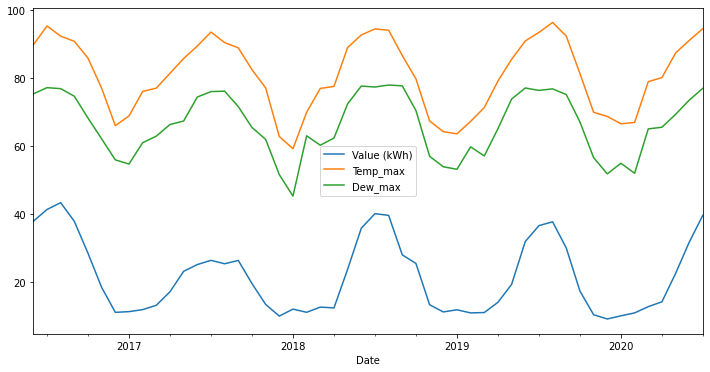

In [35]:
#Lets check the exogenous value impact on the data
df_monthly_data[['Value (kWh)','Temp_max','Dew_max']].plot(legend=True,figsize=(12,6))

So, from the plot its obivious that the Temprature and Dew plays a major role in deciding trend and seasonal component. So, we consider these two values as Exogenous values of SARIMAX

# Train Test Split

In [36]:
#lets have 75% of train data and 25% of test data
length = len(df_monthly_data)
train_split = round(length*0.75)
train_split

38

In [37]:
# using the values to filter the dataset
df_train = df_monthly_data.iloc[:train_split]
df_test = df_monthly_data.iloc[train_split-1:]
df_test.head()

,Value (kWh),Temp_max,Dew_max,d1,d2
Date,,,,,
2019-07-01,36.482916,93.451613,76.354839,4.685349,-7.958927
2019-08-01,37.606097,96.387097,76.806452,1.123181,-3.562168
2019-09-01,29.886367,92.366667,75.133333,-7.719730,-8.842911
2019-10-01,17.184548,81.322581,67.064516,-12.701818,-4.982088
2019-11-01,10.215967,69.900000,56.533333,-6.968582,5.733237


# Model Training (SARIMAX)

In [38]:
#import libs
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Train the SARIMAX model with the values provided by auto_arima and let's consider the temp and dew as exogenous variables
SARIMAX_model = SARIMAX(df_train['Value (kWh)'],exog=df_train[['Temp_max','Dew_max']],order=(0,0,3),seasonal_order=(1,1,1,12),enforce_invertibility=False)
SARIMAX_model = SARIMAX_model.fit()
SARIMAX_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Value (kWh)   No. Observations:                   38
Model:             SARIMAX(0, 0, 3)x(1, 1, [1], 12)   Log Likelihood                 -68.630
Date:                              Wed, 18 Aug 2021   AIC                            153.261
Time:                                      10:56:49   BIC                            163.326
Sample:                                  06-01-2016   HQIC                           156.159
                                       - 07-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp_max       0.3824      0.333      1.147      0.251      -0.271       1.036
Dew_max       -0.2323      0.216     -1.075      0.282      -0.656       0.191
ma.L1          0.9278      0.235      3.940      0.000       0.466       1.389
ma.L2          0.8612      0.342      2.517      0.012       0.191       1.532
ma.L3          0.3373      0.277      1.219      0.223      -0.205       0.879
ar.S.L12      -0.1808      1.040     -0.174      0.862      -2.220       1.858
ma.S.L12      -1.0001    1.3e+04  -7.69e-05      1.000   -2.55e+04    2.55e+04
sigma2         5.7092   7.43e+04   7.68e-05      1.000   -1.46e+05    1.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.98   Prob(JB):                         0.82
Heteroskedasticity (H):               0.50   Skew:                             0.28
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model Testing

In [39]:
# Obtain predicted values Monthly
start=len(df_train)
end=len(df_monthly_data)
exog_forecast = df_test[['Temp_max','Dew_max']] 
predictions = SARIMAX_model.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX((0,0,3)(1, 1, 1, 12) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'Power in Kwh')]

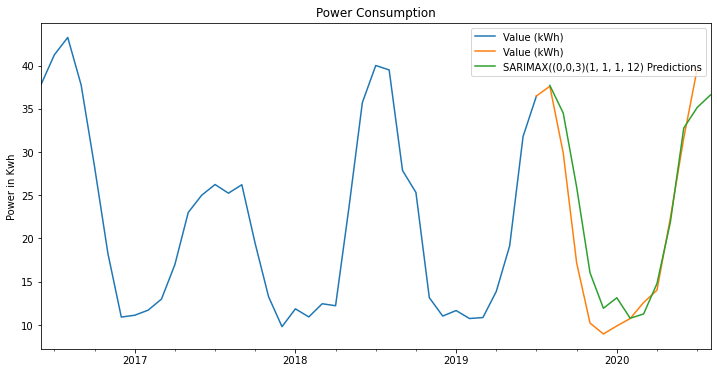

In [40]:
# Plot predictions against known values
title='Power Consumption'
ylabel='Power in Kwh'
xlabel=''

ax = df_train['Value (kWh)'].plot(legend=True,figsize=(12,6),title=title)
ax = df_test['Value (kWh)'].plot(legend=True)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# Model Evaluation

In [41]:
#import libs
from statsmodels.tools.eval_measures import mse,rmse


#calculate mse and rmse
error1 = mse(df_test['Value (kWh)'], predictions)
error2 = rmse(df_test['Value (kWh)'], predictions)

#Printing the values
print(f'SARIMAX((1,0,0)(1, 1, 0, 12) MSE Error: {error1:11.10}')
print(f'SARIMAX((1,0,0)(1, 1, 0, 12) RMSE Error: {error2:11.10}')

SARIMAX((1,0,0)(1, 1, 0, 12) MSE Error: 18.87318923
SARIMAX((1,0,0)(1, 1, 0, 12) RMSE Error: 4.344328398


In [42]:
df_monthly_data['Value (kWh)'].mean()

21.627824091991528

we could able to see the our model is performing good and it may better as we have more data.

# Conclusions

1) Algorithm tries to repeat the pattern followed in the 2018 and 2019. It has some deviations on 2020 set.

2) If we try to inclue the notes, weekend and weekday. Then, we can able to frame a good model. but we can't able to find any major deviations in values of consumption in the notes field.

3) If we are trying to smooth the series, for the 1st differencing it is not smoothen and for the 2nd it is over smoothening the values. This will also affect predictions.

# Model Deployment

# Creating function for prediction

In [179]:
def predict_power(month,year,Temp_max,Dew_max):
    day = 1
    df_date = pd.DataFrame({'year': [year],
                   'month': [month],
                   'day': [day], 'Temp_max':[float(Temp_max)], 'Dew_max':[float(Dew_max)]})

    df_date['Date'] = pd.to_datetime(df_date[["year", "month", "day"]])
    #df_date.set_index('Date', inplace=True)
    predictions = SARIMAX_model.predict(start=df_date.iloc[0]['Date'], end=df_date.iloc[0]['Date'], exog=df_date[['Temp_max','Dew_max']])
    return predictions[0]

In [181]:
predict_power(month=8,year=2019,Temp_max = 25,Dew_max = 12)

26.47274157127494

# Saving the Model as pickle file

In [184]:
import pickle
with open('House_Power_Consumption_model.pickle','wb') as f:
    pickle.dump(SARIMAX_model,f)